# Feature Basic Filtering

## Purpose
Apply basic filters to remove these problematic features:
- Extremly low coverage or high coverage features
- ENCODE Blcaklist
- Some chromosomes (usually, chrY and chrM)

## Input
- Cell metadata (after basic cell filter)
- MCDS files

## Output
- FeatureList.BasicFilter.txt: List of feature ids passed all filters

## Import

In [1]:
import pathlib
import pandas as pd
import seaborn as sns
from ALLCools.mcds import MCDS

In [2]:
from ALLCools.dataset import ALLCoolsDataset
brain_dataset = ALLCoolsDataset('/home/hanliu/cemba3c/projects/ALLCools/Brain/snmC-seq2/')

## Load Data

### Metadata

In [3]:
metadata = pd.read_csv(brain_dataset.metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 4875 cells


In [4]:
metadata.head()

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,BamFilteringRate,MappingRate,Plate,Col384,Row384,FANSDate,Slice,Sample
8E_M_10,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.005505,0.744279,0.742863,0.020649,0.015228,2714916.0,6036476,4014048.0,8E,0.676354,0.664965,CEMBA190711-8E-1,19,0,190711,8,8E_190711
8E_M_100,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.004702,0.723100,0.721792,0.012400,0.007735,3302547.0,7683706,5370970.0,8E,0.614888,0.699008,CEMBA190711-8E-2,1,2,190711,8,8E_190711
8E_M_1000,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005423,0.739960,0.738542,0.021733,0.016399,1369094.0,3658050,2381916.0,8E,0.574787,0.651144,CEMBA190711-8E-4,6,5,190711,8,8E_190711
8E_M_1002,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.004117,0.745511,0.744459,0.010192,0.006101,4571390.0,11822434,8079217.0,8E,0.565821,0.683380,CEMBA190711-8E-4,7,5,190711,8,8E_190711
8E_M_1003,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005528,0.750461,0.749074,0.023083,0.017652,1334845.0,3479288,2337068.0,8E,0.571162,0.671709,CEMBA190711-8E-3,8,4,190711,8,8E_190711


### MCDS

In [5]:
mcds = MCDS.open(brain_dataset.mcds_paths, 
                 var_dim='chrom100k', 
                 use_obs=metadata.index)
total_feature = mcds.get_index('chrom100k').size

In [6]:
mcds

<xarray.MCDS>
Dimensions:          (chrom100k: 27269, cell: 4875, count_type: 2, mc_type: 2)
Coordinates:
  * chrom100k        (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
  * cell             (cell) <U15 '8E_M_3022' '8E_M_2746' ... '8J_M_2288'
  * count_type       (count_type) <U3 'mc' 'cov'
  * mc_type          (mc_type) <U3 'CGN' 'CHN'
Data variables:
    chrom100k_chrom  (chrom100k) <U5 dask.array<chunksize=(2000,), meta=np.ndarray>
    chrom100k_da     (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1000, 2000, 2, 2), meta=np.ndarray>
    chrom100k_end    (chrom100k) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
    chrom100k_start  (chrom100k) int64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

## Filter Features

### Filter by mean coverage

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


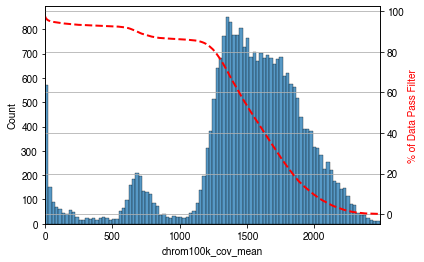

In [7]:
mcds.add_feature_cov_mean()

In [9]:
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=250,  # minimum coverage
    max_cov=3000  # Maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25440 chrom100k 93.3%


### Filter by ENCODE Blacklist

In [11]:
mcds = mcds.remove_black_list_region(
    black_list_path=brain_dataset.metadata_dir / 'mm10-blacklist.v2.bed.gz',
    f=0.2  # Features having overlap > f with any black list region will be removed.
)

1315 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


### Remove chromosomes

In [12]:
mcds = mcds.remove_chromosome(exclude_chromosome=['chrM', 'chrY'])

34 chrom100k features in ['chrM', 'chrY'] removed.


## Save Feature List

In [14]:
var_dim = 'chrom100k'
print(
    f'{mcds.get_index(var_dim).size} ({mcds.get_index(var_dim).size * 100 / total_feature:.1f}%) '
    f'{var_dim} remained after all the basic filter.')

24106 (88.4%) chrom100k remained after all the basic filter.


In [15]:
with open('FeatureList.BasicFilter.txt', 'w') as f:
    for var in mcds.get_index(var_dim).astype(str):
        f.write(var + '\n')

In [16]:
mcds

<xarray.MCDS>
Dimensions:             (chrom100k: 24106, cell: 4875, count_type: 2, mc_type: 2)
Coordinates:
  * chrom100k           (chrom100k) object 'chr1_30' 'chr1_31' ... 'chrX_1698'
  * cell                (cell) <U15 '8E_M_3022' '8E_M_2746' ... '8J_M_2288'
  * count_type          (count_type) <U3 'mc' 'cov'
  * mc_type             (mc_type) <U3 'CGN' 'CHN'
    chrom100k_cov_mean  (chrom100k) float64 1.378e+03 1.36e+03 ... 701.9 688.0
Data variables:
    chrom100k_chrom     (chrom100k) <U5 dask.array<chunksize=(1911,), meta=np.ndarray>
    chrom100k_da        (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(1000, 1911, 2, 2), meta=np.ndarray>
    chrom100k_end       (chrom100k) int64 dask.array<chunksize=(1911,), meta=np.ndarray>
    chrom100k_start     (chrom100k) int64 dask.array<chunksize=(1911,), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k